<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Mission-Brief" data-toc-modified-id="Mission-Brief-1">Mission Brief</a></span></li><li><span><a href="#Import" data-toc-modified-id="Import-2">Import</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-3">Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Calibrate" data-toc-modified-id="Calibrate-3.1">Calibrate</a></span><ul class="toc-item"><li><span><a href="#TIME-Coordinates" data-toc-modified-id="TIME-Coordinates-3.1.1">TIME Coordinates</a></span></li></ul></li></ul></li><li><span><a href="#Explore" data-toc-modified-id="Explore-4">Explore</a></span><ul class="toc-item"><li><span><a href="#Estimate-Period" data-toc-modified-id="Estimate-Period-4.1">Estimate Period</a></span></li><li><span><a href="#Folded-Timeseries" data-toc-modified-id="Folded-Timeseries-4.2">Folded Timeseries</a></span></li><li><span><a href="#Frequency" data-toc-modified-id="Frequency-4.3">Frequency</a></span></li><li><span><a href="#Spectographs" data-toc-modified-id="Spectographs-4.4">Spectographs</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-5">Model</a></span></li><li><span><a href="#Bidirectional-Sequence-Models" data-toc-modified-id="Bidirectional-Sequence-Models-6">Bidirectional Sequence Models</a></span></li><li><span><a href="#STARSKØPE" data-toc-modified-id="STARSKØPE-7"><code>STARSKØPE</code></a></span></li></ul></div>

# Mission Brief

I. Baseline Model (RNN-LSTM)


Objective: Develop single-layer, bidirectional RNN-LSTM as Baseline Model

*INPUT LAYER*

    > Timeseries Photometry
        |- Import datasets : ['exoTrain.zip','exoTest.zip']
         |- Create astropy Time stamps (format=isot, delta=30min)
         |- Convert timescale: isot -> jd -> bkjd
         |- Rename flux columns with timestamps
          |- Convert flux values to units (Flux=mJy)
          |- Extract/copy subset: 42 confirmed targets
          |- Drop Label(Target) column
           |- Estimate Periods
           |- Apply Fast Fourier Transform:
           |- Calculate fundamental frequencies, save as keys
           |- Generate spectographs (Matplotlib specgrams)
           |- Run Aggregate Downsampling
           |- Apply Phase Folding 
            |- RNN Model: Get Predictions (y_hat)
            |- RNN Model: Backpropogation (auto-adjusted weights)
             |- Accuracy Scores (F1, Jaccard, Fowlkes-Mallows)

II. Second Model: Autoencoded RBMs
    
**NOTE: Objective II is located in `starskøpe-2` notebook**

MAST API QUERY: .FITs files for all k2-campaigns with confirmed targets     

> Target Pixel Files
> Combine Layers into single image projection

III. Extended Applications: Full-Frame Image analysis

**NOTE: Objective III is lovated in `starskøpe-3` notebook.**
> Full-Frame Images from TESS, Kepler, HubblE


# Import

In [1]:
# Import code packages and libraries

#****UNCOMMENT TO INSTALL :FLATIRON BOOTCAMP Package Library***#
#!pip install -U fsds_100719

In [2]:
#import fsds_100719 as fs
#from fsds_100719.imports import * # will pre-load pd,np,plt,mpl,sns
import numpy as np
import pandas as pd
import matplotlib as mpl
%matplotlib inline
from matplotlib.colors import LogNorm

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
 

font_dict={'family':'"Titillium Web", monospace','size':16}
mpl.rc('font',**font_dict)





#ignore pink warnings
import warnings
warnings.filterwarnings('ignore')
# Allow for large # columns
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows','')

In [3]:
# # # # astro.py for extremely useful astronomical tools
# # # # uncomment items below to install 

# !pip install astropy astroquery
# !pip install astropy spectral-cube
# !pip install astropy reproject

In [4]:
import os, glob, sys

home = os.path.abspath(os.curdir)

os.listdir(home)

['sparknotes.txt',
 '.DS_Store',
 'starskøpe-1.ipynb',
 'app',
 'LICENSE',
 'Icon\r',
 'starskøpe-2.ipynb',
 'models',
 'todo.md',
 'README.md',
 '__MACOSX',
 '.gitignore',
 '_config.yml',
 'footnotes',
 '.ipynb_checkpoints',
 'README-draft.md',
 'DONT_PANIC',
 '.git',
 'exoTrain.csv',
 'data',
 'notebooks',
 'pyFunc']

In [5]:
# %cd ../
%cd data
%ls

/Users/hakkeray/CODE/DATASCIENCE/BOOTCAMP/CAPSTONE/starskope/data
Icon?                                 exoTest.csv.zip
__MACOSX/                             exoTrain.csv
cumulative.csv                        exoTrain.csv.zip
emissionspec_2020.01.30_19.43.11.csv  exodata.zip
exoTableDraw.R                        oec.csv
exoTest.csv                           transitspec_2020.01.30_19.38.06.csv


In [6]:
# !unzip -q 'exoTrain.csv.zip'
# !unzip -q 'exoTest.csv.zip'
# %ls

In [7]:
train = pd.read_csv('exoTrain.csv')
test = pd.read_csv('exoTest.csv')

In [8]:
# cd backto home / root directory
%cd ../

/Users/hakkeray/CODE/DATASCIENCE/BOOTCAMP/CAPSTONE/starskope


In [9]:
display(train.head(), test.head())

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,FLUX.40,FLUX.41,...,FLUX.3156,FLUX.3157,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,-207.47,-154.88,-173.71,-146.56,-120.26,-102.85,-98.71,-48.42,-86.57,-0.84,-25.85,-67.39,-36.55,-87.01,-97.72,-131.59,-134.80,-186.97,-244.32,-225.76,-229.60,-253.48,-145.74,-145.74,30.47,-173.39,-187.56,-192.88,-182.76,-195.99,-208.31,...,-367.84,-317.51,-167.69,-56.86,7.56,37.40,-81.13,-20.10,-30.34,-320.48,-320.48,-287.72,-351.25,-70.07,-194.34,-106.47,-14.80,63.13,130.03,76.43,131.90,-193.16,-193.16,-89.26,-17.56,-17.31,125.62,68.87,100.01,-9.60,-25.39,-16.51,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,-86.51,-74.97,-73.15,-86.13,-76.57,-61.27,-37.23,-48.53,-30.96,-8.14,-5.54,15.79,45.71,10.61,40.66,16.70,15.18,11.98,-203.70,19.13,19.13,19.13,19.13,19.13,17.02,-8.50,-13.87,-29.10,-34.29,-24.68,-27.62,...,-51.99,-32.14,-36.75,-15.49,-13.24,20.46,-1.47,-0.40,27.80,-58.20,-58.20,-72.04,-58.01,-30.92,-13.42,-13.98,-5.43,8.71,1.80,36.59,-9.80,-19.53,-19.53,-24.32,-23.88,-33.07,-9.03,3.75,11.61,-12.66,-5.69,12.53,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,469.66,462.30,492.23,441.20,483.17,481.28,535.31,554.34,562.80,540.14,576.34,551.67,556.69,550.86,577.33,562.08,577.97,530.67,553.27,538.33,527.17,532.50,273.66,273.66,292.39,298.44,252.64,233.58,171.41,224.02,237.69,...,-106.97,-56.38,-51.09,-33.30,-61.53,-89.61,-69.17,-86.47,-140.91,-84.20,-84.20,-89.09,-55.44,-61.05,-29.17,-63.80,-57.61,2.70,-31.25,-47.09,-6.53,14.00,14.00,-25.05,-34.98,-32.08,-17.06,-27.77,7.86,-70.77,-64.44,-83.83,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,311.14,326.19,313.11,313.89,317.96,330.92,341.10,360.58,370.29,369.71,339.00,336.24,319.31,321.56,308.02,296.82,279.34,275.78,289.67,281.33,285.37,281.87,88.75,88.75,67.71,74.46,69.34,76.51,80.26,70.31,63.67,...,-30.46,-32.40,-2.75,14.29,-14.18,-25.14,-13.43,-14.74,2.24,-31.07,-31.07,-50.27,-39.22,-51.33,-18.53,-1.99,10.43,-1.97,-15.32,-23.38,-27.71,-36.12,-36.12,-15.65,6.63,10.66,-8.57,-8.29,-21.90,-25.80,-29.86,7.42,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,-933.30,-889.49,-888.66,-853.95,-800.91,-754.48,-717.24,-649.34,-605.71,-575.62,-526.37,-490.12,-458.73,-447.76,-419.54,-410.76,-404.10,-425.38,-397.29,-412.73,-446.49,-413.46,-1006.21,-1006.21,-973.29,-986.01,-975.88,-982.20,-953.73,-964.35,-956.60,...,-848.88,-732.66,-694.76,-705.01,-625.24,-604.16,-668.26,-742.18,-820.55,-874.76,-874.76,-853.68,-808.62,-777.88,-712.62,-694.01,-655.74,-599.74,-617.30,-602.98,-539.29,-672.71,-672.71,-594.49,-597.60,-560.77,-501.95,-461.62,-468.59,-513.24,-504.70,-521.95,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,FLUX.40,FLUX.41,...,FLUX.3156,FLUX.3157,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,-21.97,-23.17,-29.26,-33.99,-6.25,-28.12,-27.24,-32.28,-12.29,-16.57,-23.86,-5.69,9.24,35.52,81.20,116.49,133.99,148.97,174.15,187.77,215.30,246.80,-56.68,-56.68,-56.68,-52.05,-31.52,-31.15,-48.53,-38.93,-26.06,6.63,...,3.45,6.49,-2.55,12.26,-7.06,-23.53,2.54,30.21,38.87,-22.86,-22.86,-4.37,2.27,-16.27,-30.84,-7.21,-4.27,13.60,15.62,31.96,49.89,86.93,86.93,42.99,48.76,22.82,32.79,30.76,14.55,10.92,22.68,5.91,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,5458.80,5329.39,5191.38,5031.39,4769.89,4419.66,4218.92,3924.73,3605.30,3326.55,3021.20,2800.61,2474.48,2258.33,1951.69,1749.86,1585.38,1575.48,1568.41,1661.08,1977.33,2425.62,2889.61,3847.64,3847.64,3741.20,3453.47,3202.61,2923.73,2694.84,2474.22,2195.09,...,574.19,-216.31,-3470.75,-4510.72,-5013.41,-3636.05,-2324.27,-2688.55,-2813.66,-586.22,-586.22,-756.80,-1090.23,-1388.61,-1745.36,-2015.28,-2359.06,-2516.66,-2699.31,-2777.55,-2732.97,1167.39,1167.39,1368.89,1434.80,1360.75,1148.44,1117.67,714.86,419.02,57.06,-175.66,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,150.46,85.49,-20.12,-35.88,-65.59,-15.12,16.60,-25.70,61.88,53.18,64.32,72.38,100.35,67.26,14.71,-16.41,-147.46,-231.27,-320.29,-407.82,-450.48,-146.99,-146.99,-146.99,-146.99,-166.30,-139.90,-96.41,-23.49,13.59,67.59,32.09,...,-112.96,-129.34,-35.24,-70.13,-35.30,-56.48,-74.60,-115.18,-8.91,-37.59,-37.59,-37.43,-104.23,-101.45,-107.35,-109.82,-126.27,-170.32,-117.85,-32.30,-70.18,314.29,314.29,314.29,149.71,54.60,12.60,-133.68,-78.16,-52.30,-8.55,-19.73,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,-679.56,-706.03,-720.56,-631.12,-659.16,-672.03,-665.06,-667.94,-660.84,-672.75,-644.91,-680.53,-620.50,-570.34,-530.00,-537.88,-578.38,-532.34,-532.38,-491.03,-485.03,-427.19,-380.84,-329.50,-286.91,-283.81,-298.19,-271.03,-268.50,-209.56,-180.44,-136.25,...,81.06,110.88,16.50,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-14.94,64.09,8.38,45.31,100.72,91.53,46.69,20.34,30.94,-36.81,-33.28,-69.62,-208.00,-280.28,-340.41,-337.41,-268.03,-245.00,-230.62,-129.59,-35.47,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,14.62,-19.52,-11.43,-49.80,25.84,11.62,3.18,-9.59,14.49,8.82,32.32,-28.90,-28.90,-14.09,-30.87,-18.99,-38.60,-27.79,9.65,29.60,7.88,42.87,27.59,27.05,20.26,29.48,9.71,22.84,25.99,-667.55,-1336.24,-1207.88,...,-203.96,-171.62,-122.12,-32.01,-47.15,-56.45,-41.71,-34.13,-43.12,-53.63,-53.63,-53.63,-24.29,22.29,25.18,1.84,-22.29,-26.43,-12.12,-33.05,-21.66,-228.32,-228.32,-228.32,-187.35,-166.23,-115.54,-50.18,-37.96,-22.37,-4.74,-35.82,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


In [10]:
display(train['LABEL'].value_counts(),test['LABEL'].value_counts())

1    5050
2      37
Name: LABEL, dtype: int64

1    565
2      5
Name: LABEL, dtype: int64

In [11]:
train.isna().sum().value_counts()

0    3198
dtype: int64

In [12]:
test.isna().sum().value_counts()

0    3198
dtype: int64

In [13]:
## Compare: Exoplanet vs Non-exoplanet Host Stars

# look at the first Star in the dataset (label = 2 means confirmed host of exoplanet)
starA = train.iloc[0, :]
starA.head()

LABEL      2.00
FLUX.1    93.85
FLUX.2    83.81
FLUX.3    20.10
FLUX.4   -26.98
Name: 0, dtype: float64

In [14]:
# non-exoplanet host star in last row of index (5086 or -1)
starB = train.iloc[-1, :]
starB.head()

LABEL       1.00
FLUX.1    323.28
FLUX.2    306.36
FLUX.3    293.16
FLUX.4    287.67
Name: 5086, dtype: float64

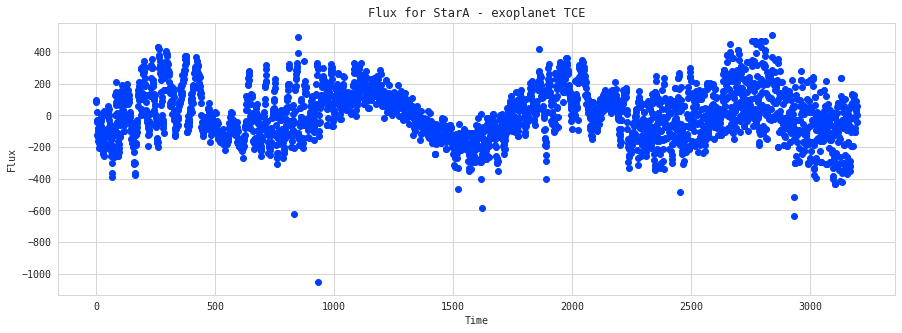

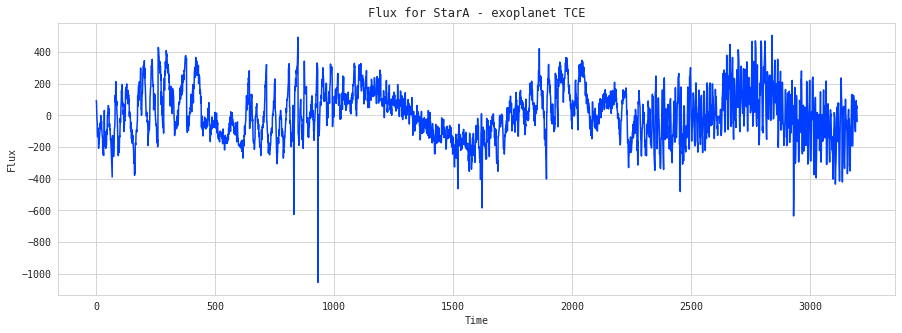

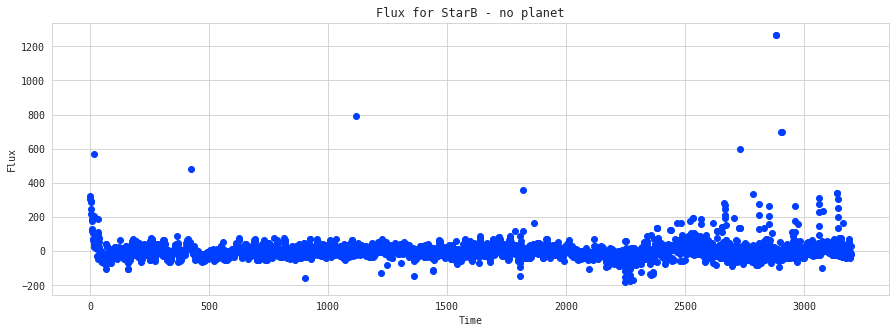

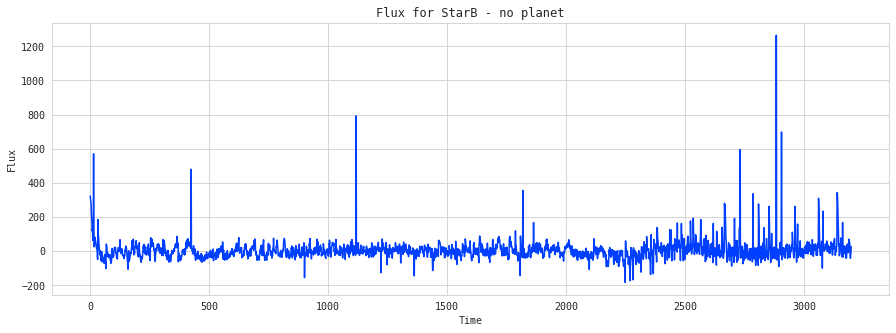

In [15]:
# Scatter Plot For First Star
plt.figure(figsize=(15, 5))
plt.scatter(pd.Series([i for i in range(1, len(starA))]), starA[1:])
plt.ylabel('Flux')
plt.xlabel('Time')
plt.title('Flux for StarA - exoplanet TCE')
plt.show()

# Line Plot For First Star
plt.figure(figsize=(15, 5))
plt.plot(pd.Series([i for i in range(1, len(starA))]), starA[1:])
plt.ylabel('Flux')
plt.xlabel('Time')
plt.title('Flux for StarA - exoplanet TCE')
plt.show()


# Scatter Plot For Last Star
plt.figure(figsize=(15, 5))
plt.scatter(pd.Series([i for i in range(1, len(starB))]), starB[1:])
plt.ylabel('Flux')
plt.xlabel('Time')
plt.title('Flux for StarB - no planet')
plt.show()

# Line Plot For last Star
plt.figure(figsize=(15, 5))
plt.plot(pd.Series([i for i in range(1, len(starB))]), starB[1:])
plt.ylabel('Flux')
plt.xlabel('Time')
plt.title('Flux for StarB - no planet')
plt.show()


# Preprocessing

In [16]:
# Before separating target column let's extract a subset of 42 confirmed planet stars 
# (rows with Label=2) and save them in another location

# P.H.I. = 'Planet Host Index'
PHI = train.loc[train['LABEL'] == 2]
PHI

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,FLUX.40,FLUX.41,...,FLUX.3156,FLUX.3157,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,-207.47,-154.88,-173.71,-146.56,-120.26,-102.85,-98.71,-48.42,-86.57,-0.84,-25.85,-67.39,-36.55,-87.01,-97.72,-131.59,-134.80,-186.97,-244.32,-225.76,-229.60,-253.48,-145.74,-145.74,30.47,-173.39,-187.56,-192.88,-182.76,-195.99,-208.31,...,-367.84,-317.51,-167.69,-56.86,7.56,37.40,-81.13,-20.10,-30.34,-320.48,-320.48,-287.72,-351.25,-70.07,-194.34,-106.47,-14.80,63.13,130.03,76.43,131.90,-193.16,-193.16,-89.26,-17.56,-17.31,125.62,68.87,100.01,-9.60,-25.39,-16.51,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,-86.51,-74.97,-73.15,-86.13,-76.57,-61.27,-37.23,-48.53,-30.96,-8.14,-5.54,15.79,45.71,10.61,40.66,16.70,15.18,11.98,-203.70,19.13,19.13,19.13,19.13,19.13,17.02,-8.50,-13.87,-29.10,-34.29,-24.68,-27.62,...,-51.99,-32.14,-36.75,-15.49,-13.24,20.46,-1.47,-0.40,27.80,-58.20,-58.20,-72.04,-58.01,-30.92,-13.42,-13.98,-5.43,8.71,1.80,36.59,-9.80,-19.53,-19.53,-24.32,-23.88,-33.07,-9.03,3.75,11.61,-12.66,-5.69,12.53,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,469.66,462.30,492.23,441.20,483.17,481.28,535.31,554.34,562.80,540.14,576.34,551.67,556.69,550.86,577.33,562.08,577.97,530.67,553.27,538.33,527.17,532.50,273.66,273.66,292.39,298.44,252.64,233.58,171.41,224.02,237.69,...,-106.97,-56.38,-51.09,-33.30,-61.53,-89.61,-69.17,-86.47,-140.91,-84.20,-84.20,-89.09,-55.44,-61.05,-29.17,-63.80,-57.61,2.70,-31.25,-47.09,-6.53,14.00,14.00,-25.05,-34.98,-32.08,-17.06,-27.77,7.86,-70.77,-64.44,-83.83,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,311.14,326.19,313.11,313.89,317.96,330.92,341.10,360.58,370.29,369.71,339.00,336.24,319.31,321.56,308.02,296.82,279.34,275.78,289.67,281.33,285.37,281.87,88.75,88.75,67.71,74.46,69.34,76.51,80.26,70.31,63.67,...,-30.46,-32.40,-2.75,14.29,-14.18,-25.14,-13.43,-14.74,2.24,-31.07,-31.07,-50.27,-39.22,-51.33,-18.53,-1.99,10.43,-1.97,-15.32,-23.38,-27.71,-36.12,-36.12,-15.65,6.63,10.66,-8.57,-8.29,-21.90,-25.80,-29.86,7.42,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,-933.30,-889.49,-888.66,-853.95,-800.91,-754.48,-717.24,-649.34,-605.71,-575.62,-526.37,-490.12,-458.73,-447.76,-419.54,-410.76,-404.10,-425.38,-397.29,-412.73,-446.49,-413.46,-1006.21,-1006.21,-973.29,-986.01,-975.88,-982.20,-953.73,-964.35,-956.60,...,-848.88,-732.66,-694.76,-705.01,-625.24,-604.16,-668.26,-742.18,-820.55,-874.76,-874.76,-853.68,-808.62,-777.88,-712.62,-694.01,-655.74,-599.74,-617.30,-602.98,-539.29,-672.71,-672.71,-594.49,-597.60,-560.77,-501.95,-461.62,-468.59,-513.24,-504.70,-521.95,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
5,2,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,139.34,146.76,149.16,162.55,159.35,173.32,108.24,175.35,143.40,119.30,168.29,111.73,123.88,111.99,95.35,139.62,127.99,66.95,90.45,63.15,64.90,-5.26,21.18,112.74,112.74,101.49,119.48,96.91,120.71,66.15,42.66,6

In [17]:
PHI.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36],
           dtype='int64')

In [18]:
# adjust index range for test before merging with train to avoid overlap/duplicate vals
idx=pd.Series([37,38,39,40,41,42])
phi2test = test.loc[test['LABEL'] == 2]


In [19]:
phi2 = pd.DataFrame(data=phi2test)
phi2

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,FLUX.40,FLUX.41,...,FLUX.3156,FLUX.3157,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,-21.97,-23.17,-29.26,-33.99,-6.25,-28.12,-27.24,-32.28,-12.29,-16.57,-23.86,-5.69,9.24,35.52,81.20,116.49,133.99,148.97,174.15,187.77,215.30,246.80,-56.68,-56.68,-56.68,-52.05,-31.52,-31.15,-48.53,-38.93,-26.06,6.63,...,3.45,6.49,-2.55,12.26,-7.06,-23.53,2.54,30.21,38.87,-22.86,-22.86,-4.37,2.27,-16.27,-30.84,-7.21,-4.27,13.60,15.62,31.96,49.89,86.93,86.93,42.99,48.76,22.82,32.79,30.76,14.55,10.92,22.68,5.91,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,5458.80,5329.39,5191.38,5031.39,4769.89,4419.66,4218.92,3924.73,3605.30,3326.55,3021.20,2800.61,2474.48,2258.33,1951.69,1749.86,1585.38,1575.48,1568.41,1661.08,1977.33,2425.62,2889.61,3847.64,3847.64,3741.20,3453.47,3202.61,2923.73,2694.84,2474.22,2195.09,...,574.19,-216.31,-3470.75,-4510.72,-5013.41,-3636.05,-2324.27,-2688.55,-2813.66,-586.22,-586.22,-756.80,-1090.23,-1388.61,-1745.36,-2015.28,-2359.06,-2516.66,-2699.31,-2777.55,-2732.97,1167.39,1167.39,1368.89,1434.80,1360.75,1148.44,1117.67,714.86,419.02,57.06,-175.66,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,150.46,85.49,-20.12,-35.88,-65.59,-15.12,16.60,-25.70,61.88,53.18,64.32,72.38,100.35,67.26,14.71,-16.41,-147.46,-231.27,-320.29,-407.82,-450.48,-146.99,-146.99,-146.99,-146.99,-166.30,-139.90,-96.41,-23.49,13.59,67.59,32.09,...,-112.96,-129.34,-35.24,-70.13,-35.30,-56.48,-74.60,-115.18,-8.91,-37.59,-37.59,-37.43,-104.23,-101.45,-107.35,-109.82,-126.27,-170.32,-117.85,-32.30,-70.18,314.29,314.29,314.29,149.71,54.60,12.60,-133.68,-78.16,-52.30,-8.55,-19.73,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,-679.56,-706.03,-720.56,-631.12,-659.16,-672.03,-665.06,-667.94,-660.84,-672.75,-644.91,-680.53,-620.50,-570.34,-530.00,-537.88,-578.38,-532.34,-532.38,-491.03,-485.03,-427.19,-380.84,-329.50,-286.91,-283.81,-298.19,-271.03,-268.50,-209.56,-180.44,-136.25,...,81.06,110.88,16.50,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-14.94,64.09,8.38,45.31,100.72,91.53,46.69,20.34,30.94,-36.81,-33.28,-69.62,-208.00,-280.28,-340.41,-337.41,-268.03,-245.00,-230.62,-129.59,-35.47,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,14.62,-19.52,-11.43,-49.80,25.84,11.62,3.18,-9.59,14.49,8.82,32.32,-28.90,-28.90,-14.09,-30.87,-18.99,-38.60,-27.79,9.65,29.60,7.88,42.87,27.59,27.05,20.26,29.48,9.71,22.84,25.99,-667.55,-1336.24,-1207.88,...,-203.96,-171.62,-122.12,-32.01,-47.15,-56.45,-41.71,-34.13,-43.12,-53.63,-53.63,-53.63,-24.29,22.29,25.18,1.84,-22.29,-26.43,-12.12,-33.05,-21.66,-228.32,-228.32,-228.32,-187.35,-166.23,-115.54,-50.18,-37.96,-22.37,-4.74,-35.82,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


In [20]:
phi2 = phi2.rename(index=idx)
phi2

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,FLUX.40,FLUX.41,...,FLUX.3156,FLUX.3157,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
37,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,-21.97,-23.17,-29.26,-33.99,-6.25,-28.12,-27.24,-32.28,-12.29,-16.57,-23.86,-5.69,9.24,35.52,81.20,116.49,133.99,148.97,174.15,187.77,215.30,246.80,-56.68,-56.68,-56.68,-52.05,-31.52,-31.15,-48.53,-38.93,-26.06,6.63,...,3.45,6.49,-2.55,12.26,-7.06,-23.53,2.54,30.21,38.87,-22.86,-22.86,-4.37,2.27,-16.27,-30.84,-7.21,-4.27,13.60,15.62,31.96,49.89,86.93,86.93,42.99,48.76,22.82,32.79,30.76,14.55,10.92,22.68,5.91,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
38,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,5458.80,5329.39,5191.38,5031.39,4769.89,4419.66,4218.92,3924.73,3605.30,3326.55,3021.20,2800.61,2474.48,2258.33,1951.69,1749.86,1585.38,1575.48,1568.41,1661.08,1977.33,2425.62,2889.61,3847.64,3847.64,3741.20,3453.47,3202.61,2923.73,2694.84,2474.22,2195.09,...,574.19,-216.31,-3470.75,-4510.72,-5013.41,-3636.05,-2324.27,-2688.55,-2813.66,-586.22,-586.22,-756.80,-1090.23,-1388.61,-1745.36,-2015.28,-2359.06,-2516.66,-2699.31,-2777.55,-2732.97,1167.39,1167.39,1368.89,1434.80,1360.75,1148.44,1117.67,714.86,419.02,57.06,-175.66,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
39,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,150.46,85.49,-20.12,-35.88,-65.59,-15.12,16.60,-25.70,61.88,53.18,64.32,72.38,100.35,67.26,14.71,-16.41,-147.46,-231.27,-320.29,-407.82,-450.48,-146.99,-146.99,-146.99,-146.99,-166.30,-139.90,-96.41,-23.49,13.59,67.59,32.09,...,-112.96,-129.34,-35.24,-70.13,-35.30,-56.48,-74.60,-115.18,-8.91,-37.59,-37.59,-37.43,-104.23,-101.45,-107.35,-109.82,-126.27,-170.32,-117.85,-32.30,-70.18,314.29,314.29,314.29,149.71,54.60,12.60,-133.68,-78.16,-52.30,-8.55,-19.73,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
40,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,-679.56,-706.03,-720.56,-631.12,-659.16,-672.03,-665.06,-667.94,-660.84,-672.75,-644.91,-680.53,-620.50,-570.34,-530.00,-537.88,-578.38,-532.34,-532.38,-491.03,-485.03,-427.19,-380.84,-329.50,-286.91,-283.81,-298.19,-271.03,-268.50,-209.56,-180.44,-136.25,...,81.06,110.88,16.50,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-14.94,64.09,8.38,45.31,100.72,91.53,46.69,20.34,30.94,-36.81,-33.28,-69.62,-208.00,-280.28,-340.41,-337.41,-268.03,-245.00,-230.62,-129.59,-35.47,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
41,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,14.62,-19.52,-11.43,-49.80,25.84,11.62,3.18,-9.59,14.49,8.82,32.32,-28.90,-28.90,-14.09,-30.87,-18.99,-38.60,-27.79,9.65,29.60,7.88,42.87,27.59,27.05,20.26,29.48,9.71,22.84,25.99,-667.55,-1336.24,-1207.88,...,-203.96,-171.62,-122.12,-32.01,-47.15,-56.45,-41.71,-34.13,-43.12,-53.63,-53.63,-53.63,-24.29,22.29,25.18,1.84,-22.29,-26.43,-12.12,-33.05,-21.66,-228.32,-228.32,-228.32,-187.35,-166.23,-115.54,-50.18,-37.96,-22.37,-4.74,-35.82,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


In [21]:
PHI = PHI.append(phi2)
PHI

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,FLUX.40,FLUX.41,...,FLUX.3156,FLUX.3157,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,-207.47,-154.88,-173.71,-146.56,-120.26,-102.85,-98.71,-48.42,-86.57,-0.84,-25.85,-67.39,-36.55,-87.01,-97.72,-131.59,-134.80,-186.97,-244.32,-225.76,-229.60,-253.48,-145.74,-145.74,30.47,-173.39,-187.56,-192.88,-182.76,-195.99,-208.31,...,-367.84,-317.51,-167.69,-56.86,7.56,37.40,-81.13,-20.10,-30.34,-320.48,-320.48,-287.72,-351.25,-70.07,-194.34,-106.47,-14.80,63.13,130.03,76.43,131.90,-193.16,-193.16,-89.26,-17.56,-17.31,125.62,68.87,100.01,-9.60,-25.39,-16.51,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,-86.51,-74.97,-73.15,-86.13,-76.57,-61.27,-37.23,-48.53,-30.96,-8.14,-5.54,15.79,45.71,10.61,40.66,16.70,15.18,11.98,-203.70,19.13,19.13,19.13,19.13,19.13,17.02,-8.50,-13.87,-29.10,-34.29,-24.68,-27.62,...,-51.99,-32.14,-36.75,-15.49,-13.24,20.46,-1.47,-0.40,27.80,-58.20,-58.20,-72.04,-58.01,-30.92,-13.42,-13.98,-5.43,8.71,1.80,36.59,-9.80,-19.53,-19.53,-24.32,-23.88,-33.07,-9.03,3.75,11.61,-12.66,-5.69,12.53,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,469.66,462.30,492.23,441.20,483.17,481.28,535.31,554.34,562.80,540.14,576.34,551.67,556.69,550.86,577.33,562.08,577.97,530.67,553.27,538.33,527.17,532.50,273.66,273.66,292.39,298.44,252.64,233.58,171.41,224.02,237.69,...,-106.97,-56.38,-51.09,-33.30,-61.53,-89.61,-69.17,-86.47,-140.91,-84.20,-84.20,-89.09,-55.44,-61.05,-29.17,-63.80,-57.61,2.70,-31.25,-47.09,-6.53,14.00,14.00,-25.05,-34.98,-32.08,-17.06,-27.77,7.86,-70.77,-64.44,-83.83,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,311.14,326.19,313.11,313.89,317.96,330.92,341.10,360.58,370.29,369.71,339.00,336.24,319.31,321.56,308.02,296.82,279.34,275.78,289.67,281.33,285.37,281.87,88.75,88.75,67.71,74.46,69.34,76.51,80.26,70.31,63.67,...,-30.46,-32.40,-2.75,14.29,-14.18,-25.14,-13.43,-14.74,2.24,-31.07,-31.07,-50.27,-39.22,-51.33,-18.53,-1.99,10.43,-1.97,-15.32,-23.38,-27.71,-36.12,-36.12,-15.65,6.63,10.66,-8.57,-8.29,-21.90,-25.80,-29.86,7.42,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,-933.30,-889.49,-888.66,-853.95,-800.91,-754.48,-717.24,-649.34,-605.71,-575.62,-526.37,-490.12,-458.73,-447.76,-419.54,-410.76,-404.10,-425.38,-397.29,-412.73,-446.49,-413.46,-1006.21,-1006.21,-973.29,-986.01,-975.88,-982.20,-953.73,-964.35,-956.60,...,-848.88,-732.66,-694.76,-705.01,-625.24,-604.16,-668.26,-742.18,-820.55,-874.76,-874.76,-853.68,-808.62,-777.88,-712.62,-694.01,-655.74,-599.74,-617.30,-602.98,-539.29,-672.71,-672.71,-594.49,-597.60,-560.77,-501.95,-461.62,-468.59,-513.24,-504.70,-521.95,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
5,2,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,139.34,146.76,149.16,162.55,159.35,173.32,108.24,175.35,143.40,119.30,168.29,111.73,123.88,111.99,95.35,139.62,127.99,66.95,90.45,63.15,64.90,-5.26,21.18,112.74,112.74,101.49,119.48,96.91,120.71,66.15,42.66,6

In [22]:
idx2 = list(range(5088,5658))
idx2 = pd.Series(idx2)
idx2

0      5088
1      5089
2      5090
3      5091
4      5092
       ... 
565    5653
566    5654
567    5655
568    5656
569    5657
Length: 570, dtype: int64

In [23]:
test = test.rename(index=idx2)
test

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,FLUX.40,FLUX.41,...,FLUX.3156,FLUX.3157,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
5088,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,-21.97,-23.17,-29.26,-33.99,-6.25,-28.12,-27.24,-32.28,-12.29,-16.57,-23.86,-5.69,9.24,35.52,81.20,116.49,133.99,148.97,174.15,187.77,215.30,246.80,-56.68,-56.68,-56.68,-52.05,-31.52,-31.15,-48.53,-38.93,-26.06,6.63,...,3.45,6.49,-2.55,12.26,-7.06,-23.53,2.54,30.21,38.87,-22.86,-22.86,-4.37,2.27,-16.27,-30.84,-7.21,-4.27,13.60,15.62,31.96,49.89,86.93,86.93,42.99,48.76,22.82,32.79,30.76,14.55,10.92,22.68,5.91,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
5089,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,5458.80,5329.39,5191.38,5031.39,4769.89,4419.66,4218.92,3924.73,3605.30,3326.55,3021.20,2800.61,2474.48,2258.33,1951.69,1749.86,1585.38,1575.48,1568.41,1661.08,1977.33,2425.62,2889.61,3847.64,3847.64,3741.20,3453.47,3202.61,2923.73,2694.84,2474.22,2195.09,...,574.19,-216.31,-3470.75,-4510.72,-5013.41,-3636.05,-2324.27,-2688.55,-2813.66,-586.22,-586.22,-756.80,-1090.23,-1388.61,-1745.36,-2015.28,-2359.06,-2516.66,-2699.31,-2777.55,-2732.97,1167.39,1167.39,1368.89,1434.80,1360.75,1148.44,1117.67,714.86,419.02,57.06,-175.66,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
5090,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,150.46,85.49,-20.12,-35.88,-65.59,-15.12,16.60,-25.70,61.88,53.18,64.32,72.38,100.35,67.26,14.71,-16.41,-147.46,-231.27,-320.29,-407.82,-450.48,-146.99,-146.99,-146.99,-146.99,-166.30,-139.90,-96.41,-23.49,13.59,67.59,32.09,...,-112.96,-129.34,-35.24,-70.13,-35.30,-56.48,-74.60,-115.18,-8.91,-37.59,-37.59,-37.43,-104.23,-101.45,-107.35,-109.82,-126.27,-170.32,-117.85,-32.30,-70.18,314.29,314.29,314.29,149.71,54.60,12.60,-133.68,-78.16,-52.30,-8.55,-19.73,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
5091,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,-679.56,-706.03,-720.56,-631.12,-659.16,-672.03,-665.06,-667.94,-660.84,-672.75,-644.91,-680.53,-620.50,-570.34,-530.00,-537.88,-578.38,-532.34,-532.38,-491.03,-485.03,-427.19,-380.84,-329.50,-286.91,-283.81,-298.19,-271.03,-268.50,-209.56,-180.44,-136.25,...,81.06,110.88,16.50,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-14.94,64.09,8.38,45.31,100.72,91.53,46.69,20.34,30.94,-36.81,-33.28,-69.62,-208.00,-280.28,-340.41,-337.41,-268.03,-245.00,-230.62,-129.59,-35.47,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
5092,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,14.62,-19.52,-11.43,-49.80,25.84,11.62,3.18,-9.59,14.49,8.82,32.32,-28.90,-28.90,-14.09,-30.87,-18.99,-38.60,-27.79,9.65,29.60,7.88,42.87,27.59,27.05,20.26,29.48,9.71,22.84,25.99,-667.55,-1336.24,-1207.88,...,-203.96,-171.62,-122.12,-32.01,-47.15,-56.45,-41.71,-34.13,-43.12,-53.63,-53.63,-53.63,-24.29,22.29,25.18,1.84,-22.29,-26.43,-12.12,-33.05,-21.66,-228.32,-228.32,-228.32,-187.35,-166.23,-115.54,-50.18,-37.96,-22.37,-4.74,-35.82,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [24]:
# combine training and test datasets (we'll use our own splitting method later)

exodata = train.append(test)
exodata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5657 entries, 0 to 5657
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 138.1 MB


In [25]:
y = exodata['LABEL'] # target
X = exodata.drop(columns=['LABEL'],axis=1) # features 

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5657 entries, 0 to 5657
Columns: 3197 entries, FLUX.1 to FLUX.3197
dtypes: float64(3197)
memory usage: 138.0 MB


In [27]:
X.iloc[0]

FLUX.1       93.85
FLUX.2       83.81
FLUX.3       20.10
FLUX.4      -26.98
FLUX.5      -39.56
             ...  
FLUX.3193    92.54
FLUX.3194    39.32
FLUX.3195    61.42
FLUX.3196     5.08
FLUX.3197   -39.54
Name: 0, Length: 3197, dtype: float64

---
## Calibrate

*Astronomic Unit Conversion and Time Series Manipulation*

Triangulate Starskøpe according to units and dimensions matching the dataset (K2 campaign 3).

The `x` axis represents ~30-minute time bins ('long cadence' intervals). 

The `y` axis represents flux values that have been de-noised, called 'PDC-SAP Flux'.

### TIME Coordinates 

    KEPLER HANDBOOK

    "the total amount of time over which the data in a cadence is coadded is the cadence period, 
    which in the case of the flight default operating parameters is 1765.5 s = 0.4904 h" (1)

In [28]:
cadence_period = 3197*29.4
print(cadence_period, "minutes")#minutes = 93991.79

cp_hrs = cadence_period/60 # hours : 1598.5
print(cp_hrs, "hours")

cp_days = cp_hrs / 24
print(cp_days,"days") ## 65.27 --> Approximate time period of Campaign 3 which was cut short


93991.79999999999 minutes
1566.5299999999997 hours
65.27208333333333 days


In [29]:
from astropy.time import Time
from astropy import units as u
from astropy.timeseries import TimeSeries
from astropy.table import vstack, hstack, Table

cadence = 0.49 *u.hour
print("cadence:",cadence)

jd = 1 * u.day
jd = 24* u.hour
print("julian day:",jd)

interval = cadence/jd
print("cadence time interval in julian days:",interval)

cadence: 0.49 h
julian day: 24.0 h
cadence time interval in julian days: 0.020416666666666666


In [30]:
# k2 campaign 3 
# TIME coordinates
# isot/utc:

#start date for Campaign 3 with format ISOT, scale UTC
time_start = '2014-11-15T15:06:05.515'
time_start = Time(time_start, format='isot',scale = 'utc')

time_end ='2015-01-23T18:37:04.488'
time_end = Time(time_end, format='isot',scale = 'utc')

print(time_start)
print(time_end)

2014-11-15T15:06:05.515
2015-01-23T18:37:04.488


In [31]:
time_start

<Time object: scale='utc' format='isot' value=2014-11-15T15:06:05.515>

In [32]:
# long cadence indices
lc_start = 99599
lc_end = 102984

# convert to mjd (modified julian day)
lc_start = Time(lc_start, format='mjd', scale='tdb')
lc_start

lc_end = Time(lc_end, format='mjd', scale='tdb')
lc_end

<Time object: scale='tdb' format='mjd' value=102984.0>

In [33]:
signal = np.array(X.iloc[0])
signal

array([ 93.85,  83.81,  20.1 , ...,  61.42,   5.08, -39.54])

In [34]:
ts = TimeSeries(time_start=time_start,time_delta = 0.02*u.d,
                      data={'flux': signal * u.mJy})
print(ts)

          time            flux 
                          mJy  
----------------------- -------
2014-11-15T15:06:05.515   93.85
2014-11-15T15:34:53.515   83.81
2014-11-15T16:03:41.515    20.1
2014-11-15T16:32:29.515  -26.98
2014-11-15T17:01:17.515  -39.56
2014-11-15T17:30:05.515 -124.71
2014-11-15T17:58:53.515 -135.18
2014-11-15T18:27:41.515  -96.27
2014-11-15T18:56:29.515  -79.89
2014-11-15T19:25:17.515 -160.17
                    ...     ...
2015-01-18T08:51:41.515  -78.07
2015-01-18T09:20:29.515 -102.15
2015-01-18T09:49:17.515 -102.15
2015-01-18T10:18:05.515   25.13
2015-01-18T10:46:53.515   48.57
2015-01-18T11:15:41.515   92.54
2015-01-18T11:44:29.515   39.32
2015-01-18T12:13:17.515   61.42
2015-01-18T12:42:05.515    5.08
2015-01-18T13:10:53.515  -39.54
Length = 3197 rows


# Explore

## Estimate Period

In [48]:
# Estimate Period
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
periodogram = BoxLeastSquares.from_timeseries(ts, 'flux')

In [51]:
results = periodogram.autopower(0.02 * u.day)  
best = np.argmax(results.power)  
period = results.period[best]  
period

<Quantity 30.4453532 d>

In [52]:
transit_time = results.transit_time[best]  
transit_time

<Time object: scale='utc' format='isot' value=2014-12-04T05:44:29.515>

## Folded Timeseries

In [83]:
from astropy import units as u
from astropy.timeseries import aggregate_downsample
kepler_binned = aggregate_downsample(ts, time_bin_size=29.4 * u.min, aggregate_func=np.nanmedian)

Text(0, 0.5, 'SAP Flux (e-/s)')

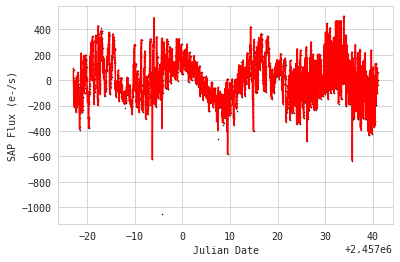

In [85]:
plt.plot(ts.time.jd, ts['flux'], 'k.', markersize=1)
plt.plot(kepler_binned.time_bin_start.jd, kepler_binned['flux'], 'r-', drawstyle='steps-pre')
plt.xlabel('Julian Date')
plt.ylabel('SAP Flux (e-/s)')

Text(0, 0.5, 'SAP Flux (e-/s)')

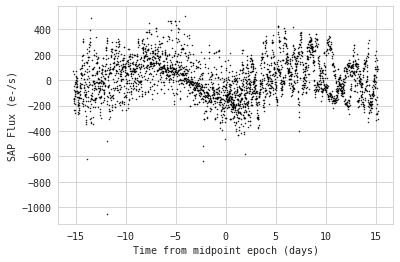

In [90]:
kepler_folded = ts.fold(period=30.44 * u.day)

plt.plot(kepler_folded.time.jd, kepler_folded['flux'], 'k.', markersize=1)
plt.xlabel('Time from midpoint epoch (days)')
plt.ylabel('SAP Flux (e-/s)')

Text(0, 0.5, 'Normalized flux')

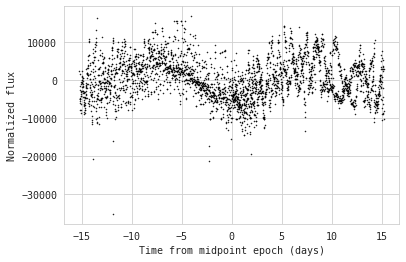

In [91]:
from astropy.stats import sigma_clipped_stats

mean, median, stddev = sigma_clipped_stats(kepler_folded['flux'])

kepler_folded['sap_flux_norm'] = kepler_folded['flux'] / median

plt.plot(kepler_folded.time.jd, kepler_folded['sap_flux_norm'], 'k.', markersize=1)
plt.xlabel('Time from midpoint epoch (days)')
plt.ylabel('Normalized flux')

## Frequency

In [ ]:
# ƒast ƒourier transform
# The routine np.fft.fftfreq(n) returns an array giving the frequencies 
# of corresponding elements in the output. 
# The routine np.fft.fftshift(A) shifts transforms and their frequencies 
#to put the zero-frequency components in the middle, 
# and np.fft.ifftshift(A) undoes that shift.

# `signal = np.array([-2, 8, 6, 4, 1, 0, 3, 5], dtype=float)`
# `fourier = np.fft.fft(signal)`
# `n = signal.size`
# `timestep = 0.1`
# `freq = np.fft.fftfreq(n, d=timestep)`
# `freq`
# `array([ 0.  ,  1.25,  2.5 ,  3.75, -5.  , -3.75, -2.5 , -1.25])`



In [53]:
signal = np.array(X.iloc[0])
f = np.fft.fft(signal)
n = signal.size
timestep = 0.02

In [54]:
freq = np.fft.fftfreq(n, d=timestep)
freq

array([ 0.        ,  0.01563966,  0.03127932, ..., -0.04691899,
       -0.03127932, -0.01563966])

In [69]:
# Shift the zero-frequency component to the center of the spectrum.
# This function swaps half-spaces for all axes listed (defaults to all). 
# Note that y[0] is the Nyquist component only if len(x) is even.

zf = np.fft.fftshift(freq)
zf

array([-24.99218017, -24.97654051, -24.96090084, ...,  24.96090084,
        24.97654051,  24.99218017])

Text(0, 0.5, 'PDC_SAP Flux (e-/s)')

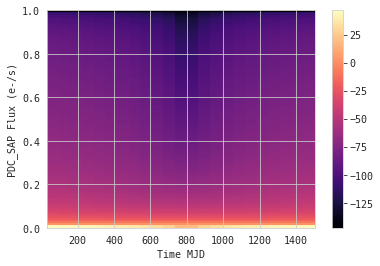

In [70]:
spec, freqs, t, m = plt.specgram(zf, Fs=Fs, cmap='magma')
plt.colorbar()
plt.xlabel('Time MJD')
plt.ylabel('PDC_SAP Flux (e-/s)')

In [72]:
3197/23

139.0

In [79]:
# Shift the zero-frequency component only along the second axis:
zf2 = np.fft.fftfreq(n, d=timestep).reshape(139, 23)

In [80]:
zf2

array([[ 0.        ,  0.01563966,  0.03127932, ...,  0.31279324,
         0.32843291,  0.34407257],
       [ 0.35971223,  0.37535189,  0.39099155, ...,  0.67250547,
         0.68814514,  0.7037848 ],
       [ 0.71942446,  0.73506412,  0.75070378, ...,  1.0322177 ,
         1.04785737,  1.06349703],
       ...,
       [-1.07913669, -1.06349703, -1.04785737, ..., -0.76634345,
        -0.75070378, -0.73506412],
       [-0.71942446, -0.7037848 , -0.68814514, ..., -0.40663122,
        -0.39099155, -0.37535189],
       [-0.35971223, -0.34407257, -0.32843291, ..., -0.04691899,
        -0.03127932, -0.01563966]])

Text(0, 0.5, 'PDC_SAP Flux (e-/s)')

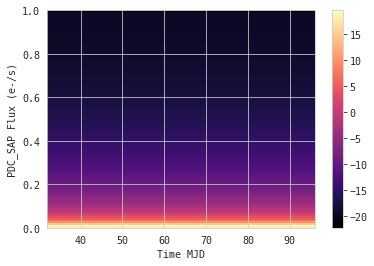

In [81]:
spec, freqs, t, m = plt.specgram(zf2, Fs=Fs, cmap='magma')
plt.colorbar()
plt.xlabel('Time MJD')
plt.ylabel('PDC_SAP Flux (e-/s)')

## Spectographs

In [35]:
signal = np.array(X.iloc[0])
signal

array([ 93.85,  83.81,  20.1 , ...,  61.42,   5.08, -39.54])

In [36]:
Fs= 2

Text(0, 0.5, 'PDC_SAP Flux (e-/s)')

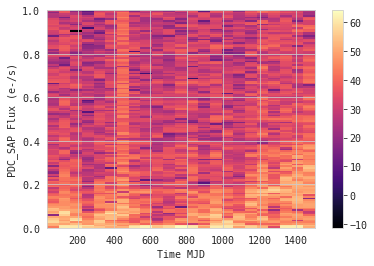

In [37]:
spec, freqs, t, m = plt.specgram(signal, Fs=Fs, cmap='magma')
plt.colorbar()
plt.xlabel('Time MJD')
plt.ylabel('PDC_SAP Flux (e-/s)')

In [38]:
def make_specgram(df):
     
        spec, freqs, t, m = plt.specgram(signal, Fs=Fs, cmap='magma')
        plt.colorbar()
        plt.xlabel('Time MJD')
        plt.ylabel('PDC_SAP Flux (e-/s)')
        return plt.show()


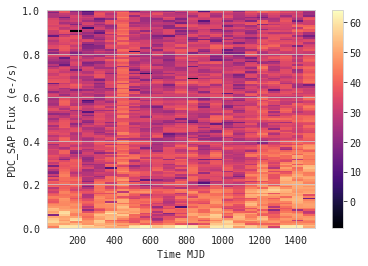

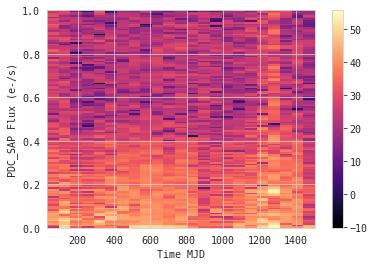

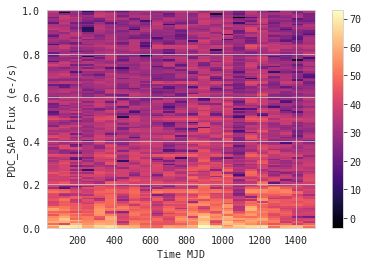

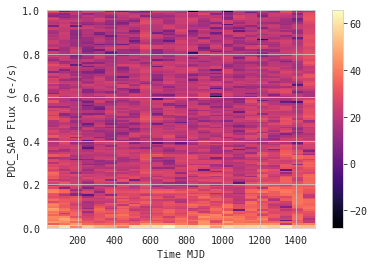

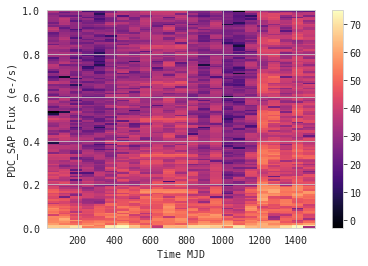

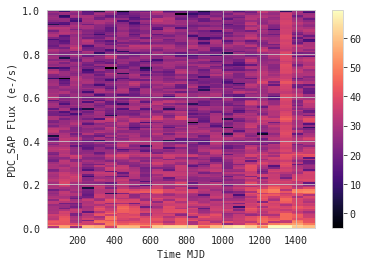

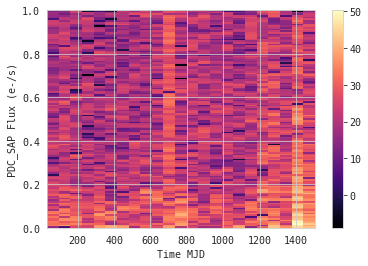

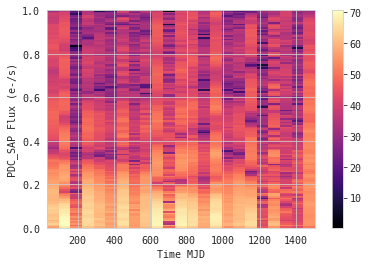

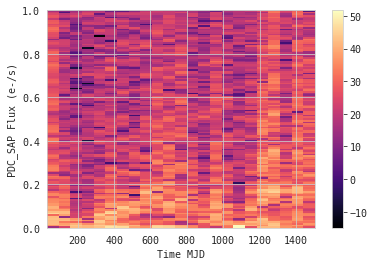

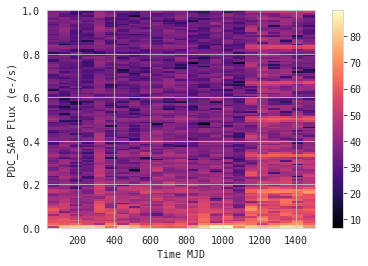

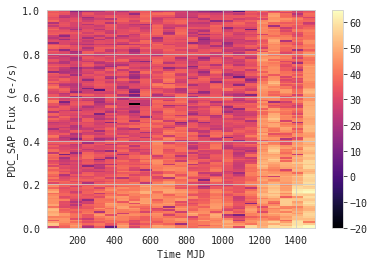

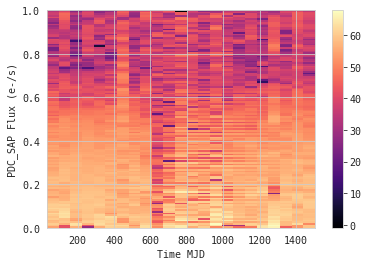

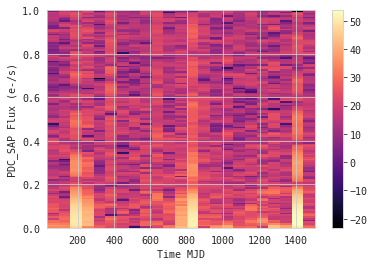

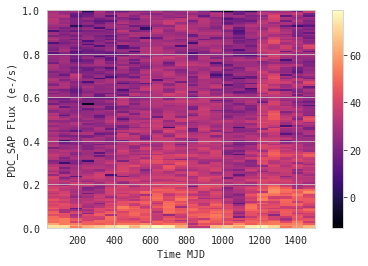

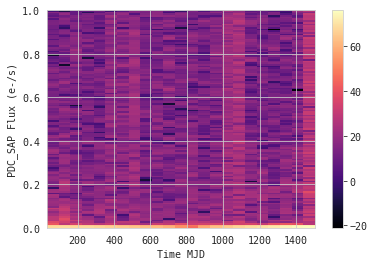

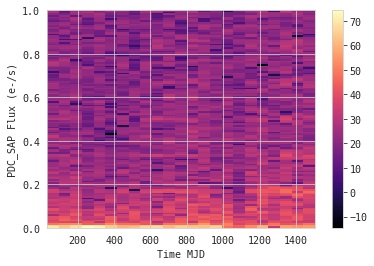

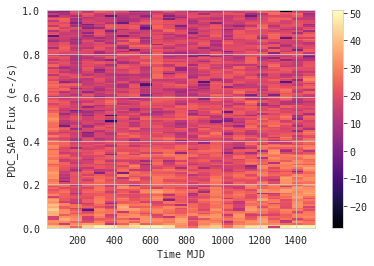

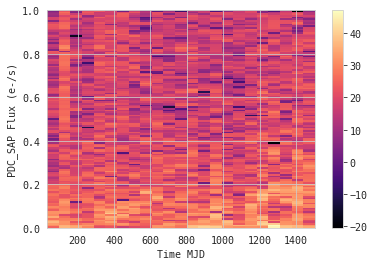

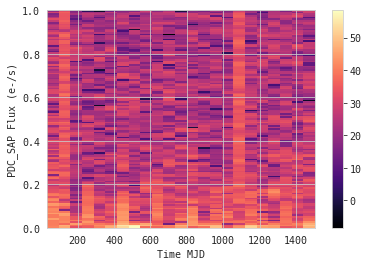

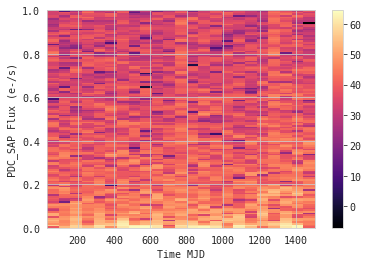

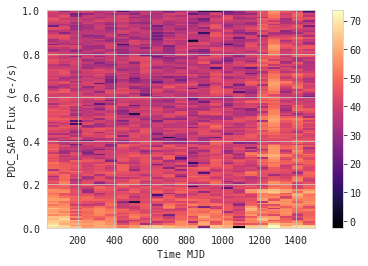

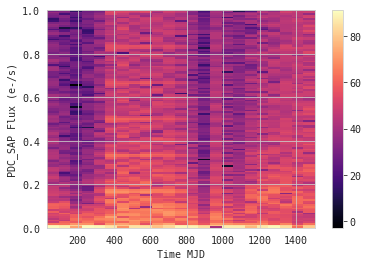

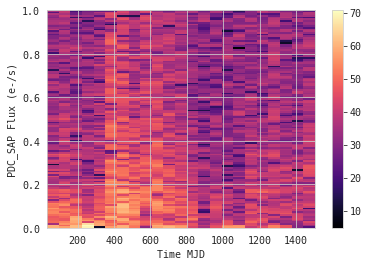

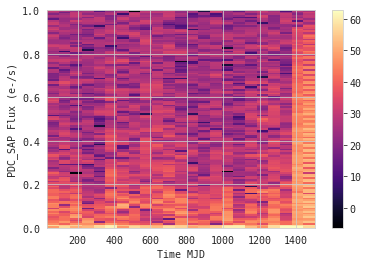

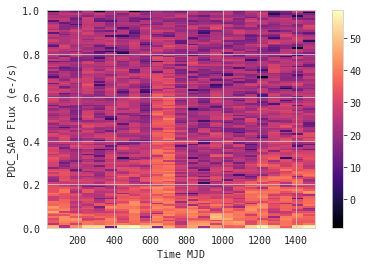

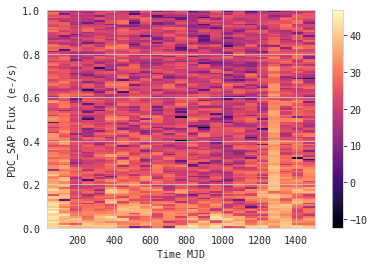

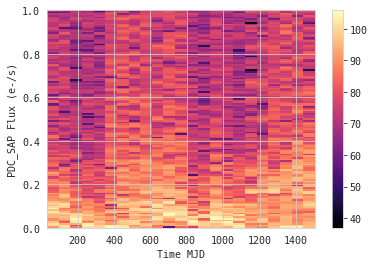

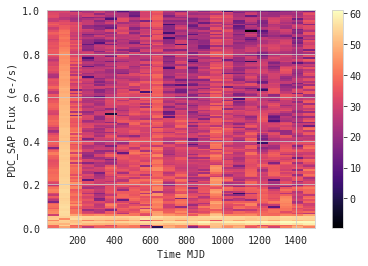

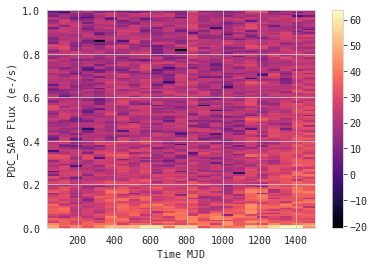

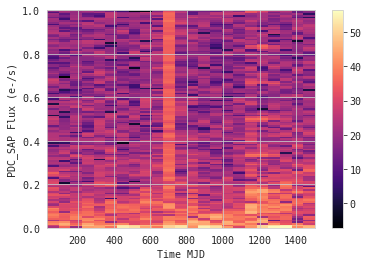

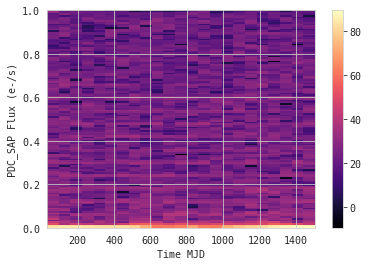

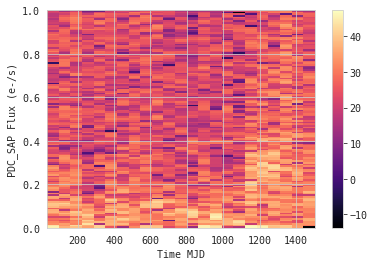

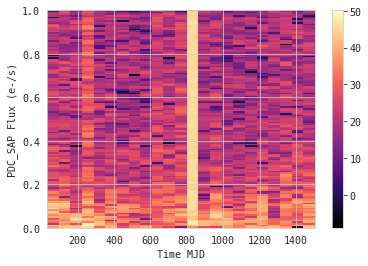

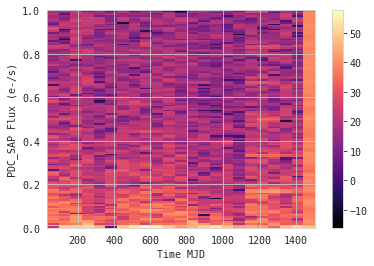

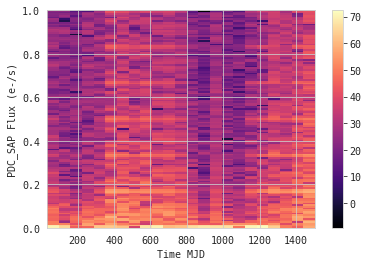

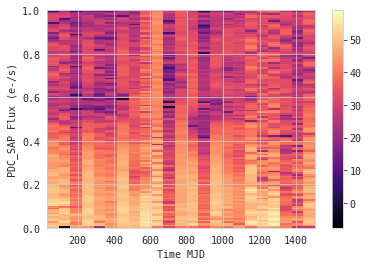

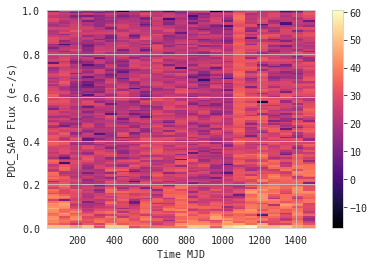

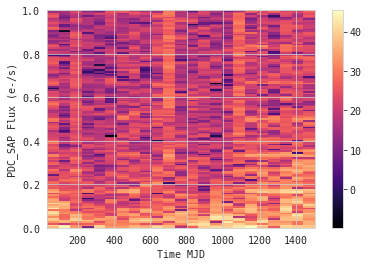

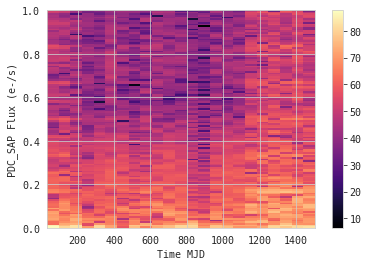

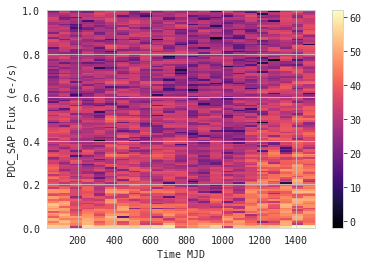

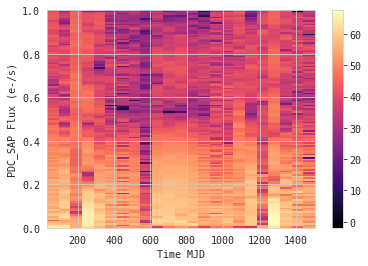

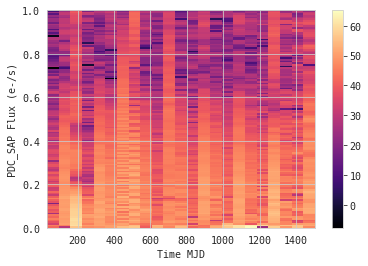

In [39]:
for i in PHI.index:
    signal = np.array(PHI.iloc[i])
    make_specgram(PHI)

# Model

In [43]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'keras'

In [45]:
### <---- TEMP* EDIT BEFORE RELEASE----> ####
#import machine learning libraries
# Uncomment below to install

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
import scipy.ndimage

!pip install xgboost
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# !pip install imblearn
# from imblearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import accuracy_score,roc_curve,auc,average_precision_score, \
recall_score,precision_score,f1_score,classification_report
from sklearn.tree import export_graphviz 
# from pydotplus import graph_from_dot_data
# from imblearn.over_sampling import SMOTE #For imbalanced datasets
#from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

!pip install keras
!pip install tensorflow
#import additional libraries for performing Keras model

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.ndimage.filters import uniform_filter1d

import random
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import models, layers, optimizers

from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam

ModuleNotFoundError: No module named 'keras'

# Bidirectional Sequence Models

In [46]:
!pip install keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'keras'

In [47]:
from keras.layers import LSTM, Dense, Bidirectional
from keras.models import Sequential

model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=True),
                        input_shape=(5, 10)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

ModuleNotFoundError: No module named 'keras'

In [ ]:
# logistic regression
pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=2)),
                   ('clf', LogisticRegression(class_weight='balanced'))])

# support vector
pipe_svm = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', svm.SVC(class_weight='balanced'))])


# decision tree
pipe_dt = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=2)),
                    ('clf', tree.DecisionTreeClassifier(class_weight='balanced'))])

# xgboost
pipe_xgb = Pipeline([('xgb', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                     ('clf', XGBClassifier(class_weight='balanced'))])

# `STARSKØPE`



**Building a Cyberoptic Neural Network Telescope for Astrophysical Object Classification**

> Flatiron School Capstone Project
* `Ru Keïn`
* `Instructor: James Irving PhD`
* `Data Science Full-Time Program`
* `Blog post URL:`
* `Non-Technical Presentation`: